In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('churn_true.csv')
df

,Unnamed: 0,Phone_Number,Account_Length,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,...,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn,Cluster,PCA1,PCA2,Day_Eve_Charge_Ratio,Night_Intl_Charge_Ratio
0,8,329-6603,65,0,129.1,137,21.95,228.5,83,19.42,...,12.7,6,3.43,4,True,1,-2.335098,-0.681739,1.130278,2.740525
1,12,351-7269,161,0,332.9,67,56.59,317.8,97,27.01,...,5.4,9,1.46,4,True,1,-0.011146,0.556287,2.095150,4.952055
2,17,393-7984,77,0,62.4,89,10.61,169.9,121,14.44,...,5.7,6,1.54,5,True,1,-4.273185,-0.064077,0.734765,6.123377
3,26,360-1596,12,0,249.6,118,42.43,252.4,119,21.45,...,11.8,3,3.19,1,True,1,-0.473658,0.186126,1.978089,3.952978
4,39,398-1294,119,0,159.1,114,27.05,231.3,117,19.66,...,8.8,3,2.38,5,True,1,-2.859719,-0.742749,1.375890,2.705882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4148,33176,769-9777,98,0,268.8,82,28.22,286.2,222,22.88,...,22.8,2,8.22,2,True,0,1.123364,-1.177309,1.233392,1.092457
4149,33190,766-8785,26,0,229.6,28,89.08,208.2,208,22.28,...,20.8,2,2.92,0,True,0,-0.063786,-1.694523,3.998205,0.780822
4150,33192,797-7979,92,0,282.2,208,89.88,229.8,209,28.22,...,2.0,2,0.82,2,True,0,0.904715,4.463308,3.184975,25.390244
4151,33194,787-9998,66,0,262.8,92,28.22,280.0,68,29.88,...,20.6,8,2.86,2,True,1,0.484861,0.128087,0.944444,3.034965


In [3]:
# Ensure 'Churn' column is properly formatted
df['Churn'] = df['Churn'].astype(int)

# Select relevant numerical columns for clustering
numerical_cols = [
    'Account_Length', 'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 
    'Eve_Mins', 'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 
    'Night_Charge', 'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls'
]

X = df[numerical_cols]

In [4]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [6]:
# Hierarchical clustering
linked = linkage(X_pca, method='ward')

In [7]:
# Determine the clusters
df['Cluster'] = fcluster(linked, t=3, criterion='maxclust')

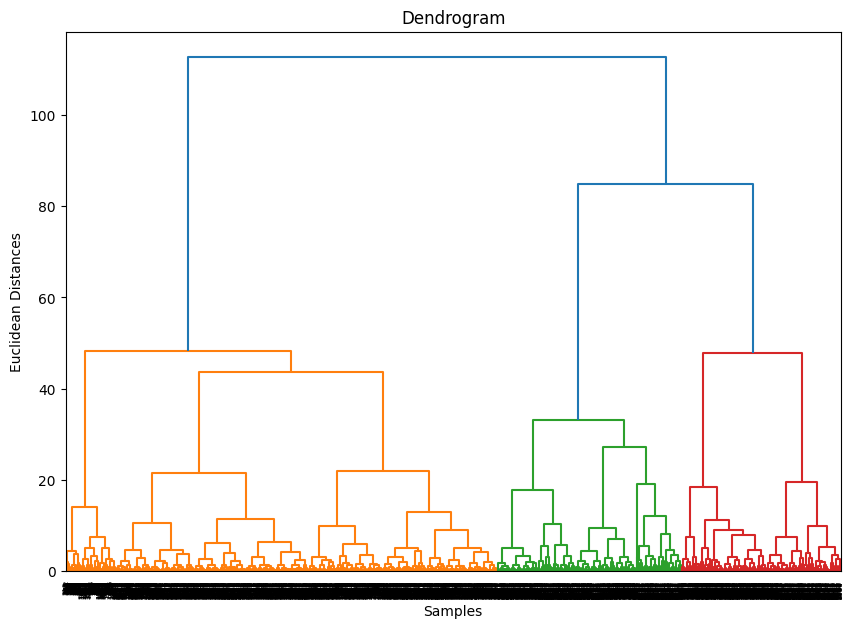

In [8]:
# Visualize the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean Distances')
plt.show()

In [9]:
# Calculate Customer Lifetime Value (CLV)
df['CLV'] = df['Day_Charge'] + df['Eve_Charge'] + df['Night_Charge'] + df['Intl_Charge']

In [10]:
# Define cluster names based on your analysis
cluster_names = {
    1: 'Potential Low Value Customers',
    2: 'Potential Medium Value Customers',
    3: 'Potential High Value Customers'
}

# Map clusters to descriptive names
df['Cluster_Name'] = df['Cluster'].map(cluster_names)

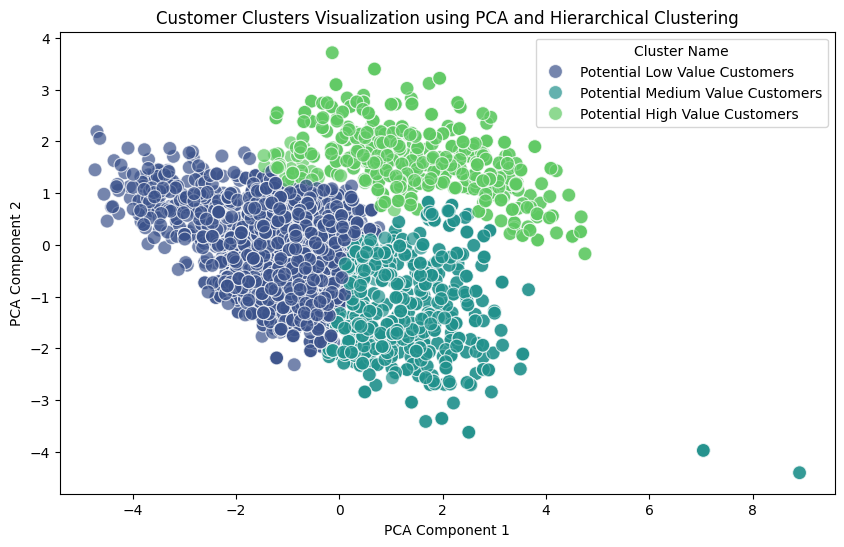

In [11]:
# Visualizing the clusters using PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue='Cluster_Name', data=df, palette='viridis', s=100, alpha=0.7)
plt.title('Customer Clusters Visualization using PCA and Hierarchical Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster Name', loc='best')
plt.show()

In [12]:
# Cluster analysis: describe statistics and CLV
cluster_analysis = {}
for i in range(1, 4):
    cluster_name = cluster_names.get(i, f'Cluster {i}')
    cluster_data = df[df['Cluster'] == i][numerical_cols].describe()
    cluster_clv_mean = df[df['Cluster'] == i]['CLV'].mean()
    churn_rate = df[df['Cluster'] == i]['Churn'].mean() * 100  # Convert to percentage
    cluster_analysis[cluster_name] = {
        'Data Description': cluster_data,
        'Average CLV': cluster_clv_mean,
        'Churn Rate': churn_rate
    }

In [13]:
# Count the number of records in each cluster
cluster_counts = df['Cluster_Name'].value_counts()

In [14]:
# Results
print("Cluster Analysis Summary:")
for cluster_name, analysis in cluster_analysis.items():
    print(f"\n{cluster_name}:\n")
    print(analysis['Data Description'])
    print(f"Average CLV: {analysis['Average CLV']:.2f}")
    print(f"Churn Rate: {analysis['Churn Rate']:.2f}%")

print("\nNumber of Records in Each Cluster:")
print(cluster_counts)

Cluster Analysis Summary:

Potential Low Value Customers:

       Account_Length  VMail_Message     Day_Mins    Day_Calls   Day_Charge  \
count     2314.000000    2314.000000  2314.000000  2314.000000  2314.000000   
mean       129.917459       5.149957   233.199784   136.474935    30.285536   
std         84.150759      13.783625    46.182660    77.485614    13.065695   
min          1.000000       0.000000    62.400000    22.000000    10.610000   
25%         45.250000       0.000000   222.300000    80.000000    22.420000   
50%         99.000000       0.000000   229.900000   109.000000    26.220000   
75%        222.000000       0.000000   262.200000   220.000000    32.627500   
max        322.000000      88.000000   424.400000   329.000000    89.200000   

          Eve_Mins    Eve_Calls   Eve_Charge   Night_Mins  Night_Calls  \
count  2314.000000  2314.000000  2314.000000  2314.000000  2314.000000   
mean    233.264564   133.090752    22.412334   231.959810   134.332325   
std    